Epoch 1, Training loss 2.138994, Validation loss 2.519636
Epoch 1000, Training loss 0.785993, Validation loss 0.587371
Epoch 2000, Training loss 0.208607, Validation loss 0.111806
Epoch 3000, Training loss 0.041332, Validation loss 0.025133
Epoch 4000, Training loss 0.008000, Validation loss 0.005960
Epoch 5000, Training loss 0.001644, Validation loss 0.001746


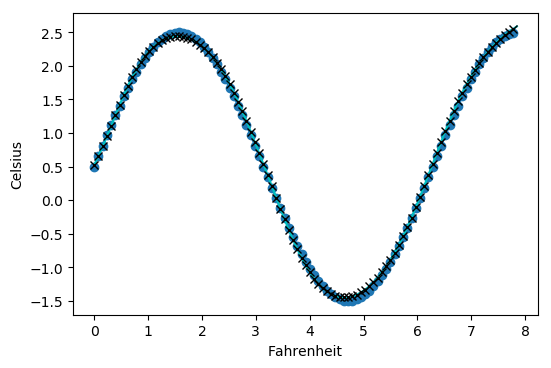

prediction: 
 [ 0.37738585  1.7026976   1.8441957   0.709654    2.2003756  -1.4051853
  0.8627267   2.4394884  -0.97149765  1.9482031   2.263146    2.127311
 -1.3963426   2.3436546   1.4686209  -0.12448794  0.37069118  2.393134
 -1.242168    2.4080415 ]
groudtruth: 
 [ 0.3430818   1.6755705   1.7988961   0.65691817  2.2052803  -1.4753767
  0.81286895  2.4938347  -0.91421354  1.9142135   2.282013    2.118034
 -1.4021131   2.347759    1.407981   -0.11803399  0.3430818   2.4447398
 -1.2052803   2.4447398 ]


In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
%matplotlib inline
from matplotlib import pyplot as plt

#可调参数：t_u与t_range中的范围，t_c的形状，SubclassFunctionalModel中隐层神经元个数

n_epochs = 5000
e_print = 1000

#-----数据处理-----
'''
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0, 13.8]
t_u = [3.57, 5.59, 5.82, 8.19, 5.63, 4.89, 3.39, 2.18, 4.84, 6.04, 6.84, 6.02]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

'''
t_u = np.arange(0., 2.5 * np.pi, 2.5 * np.pi / 100)
t_c = 2 * np.sin(t_u) + 0.5
t_u = torch.tensor(t_u).float().unsqueeze(1)
t_c = torch.tensor(t_c).float().unsqueeze(1)


#随机获取训练集与验证集索引
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

#根据索引划分训练集与验证集
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

#-----定义网络-----
class SubclassFunctionalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(1, 4)
        self.hidden2 = nn.Linear(4, 4)
        self.output = nn.Linear(4, 1)
        

    def forward(self, input):
        hidden_t1 = self.hidden1(input)
        activated_t1 = torch.tanh(hidden_t1)
        hidden_t2 = self.hidden2(activated_t1)
        activated_t2 = torch.tanh(hidden_t2)
        output_t = self.output(activated_t2)
        return output_t

#-----定义训练器-----
def training_loop(n_epochs, optimizer, model, loss_fn, 
                  t_u_train, t_u_val, t_c_train, t_c_val):
    losslist = torch.zeros(n_epochs)
    
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        loss
        
        with torch.no_grad():
            t_p_val = model(t_u_val)
            loss_val = loss_fn(t_p_val, t_c_val)
            assert loss_val.requires_grad == False
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % e_print == 0:
            print('Epoch %d, Training loss %.6f, Validation loss %.6f' % (
                    epoch, float(loss_train), float(loss_val)))

#实例化网络，定义优化器（优化器必须在网络实例化之后定义！！！否则反向传播参数不会更新）
func_model = SubclassFunctionalModel()
optimizer = optim.SGD(func_model.parameters(), lr=1e-2)

#开始训练
training_loop(
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = func_model,
    loss_fn = nn.MSELoss(), # 不再使用自己定义的loss
    t_u_train = t_u_train,
    t_u_val = t_u_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

#绘制图像
t_range = torch.arange(0., 2.5*np.pi, 2.5*np.pi/1000).unsqueeze(1)
#l_range = torch.arange(0., n_epochs).unsqueeze(1)
#losslist = losslist.unsqueeze(1)

fig = plt.figure(dpi=100)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o-')
plt.plot(t_range.numpy(), func_model(t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), func_model(t_u).detach().numpy(), 'kx')
plt.show()

'''
fig = plt.figure(dpi=100)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(l_range.numpy(), losslist.numpy(), 'c-')
'''

print('prediction: \n',func_model(t_u_val).detach().squeeze(1).numpy())
print('groudtruth: \n',t_c_val.squeeze(1).numpy())
